# DaKanjiRecognizer - Single Kanji CNN : Training

## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import random
import math
import random
import multiprocessing as mp
import gc
import time
import datetime

#reading the dataset
from etldr.etl_data_reader import ETLDataReader
from etldr.etl_character_groups import ETLCharacterGroups
from etldr.etl_data_names import ETLDataNames

#data handling
import PIL
from PIL import Image as PImage
from PIL import ImageFilter
import numpy as np

#ML
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

#creating one hot encodings
from sklearn.preprocessing import LabelBinarizer

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

Because the data sets are big let's make sure that the GPU is available to speed up training.

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


If a GPU with native 16 bit float support (ex.: RTX-series) is available, enable support for it here.

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


## Loading the data

The [ETL Character data set](http://etlcdb.db.aist.go.jp/) which I am using is a data set with multiple sub sets (ETL1 - ETL7, ETL8B, ETL8G, ETL9B and ETL9G). <br/>
After unpacking the data set I renamed all folders and files to have a uniform naming scheme: "ETLX/ETLX_Y". "X" is the number of the subset and Y the part of the subset. Also ETL7S was removed (ETL7L just smaller), the following renaming was also done: <br/>
ETL8B $\rightarrow$ ETL1, ETL8G $\rightarrow$ ETL9, ETL9B $\rightarrow$ ETL10 and ETL9G $\rightarrow$ ETL11.<br/>
This leads to the following data set structure: <br/> 

| name  |   type  |                    content                                              |   res   | Bit depth |    code    | samples perlabel | total samples |
|:-----:|:-------:|:-----------------------------------------------------------------------:|:-------:|:---------:|:----------:|:----------------:|:-------------:|
| ETL1  | M-Type  | Numbers <br/> Roman <br/> Symbols <br/> Katakana                        |  64x63  |     4     | JIS X 0201 |   ~1400          |     141319    |
| ETL2  | K-Type  | Hiragana <br/> Katakana <br/> Kanji <br/> Roman <br/> Symbols           |  60x60  |     6     |    CO59    |     ~24          |      52796    |
| ETL3  | C-Type  | Numeric <br/> Capital Roman <br/> Symbols                               |  72x76  |     4     | JIS X 0201 |     200          |       9600    |
| ETL4  | C-Type  | Hiragana                                                                |  72x76  |     4     | JIS X 0201 |     120          |       6120    |
| ETL5  | C-Type  | Katakana                                                                |  72x76  |     4     | JIS X 0201 |    ~200          |      10608    |
| ETL6  | M-Type  | Katakana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |    1383          |     157662    |
| ETL7  | M-Type  | Hiragana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |     160          |      16800    |
| ETL8  | 8B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     157662    |
| ETL9  | 8G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |
| ETL10 | 9B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     152960    |
| ETL11 | 9G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |


Because the provided data set is distributed in a proprietary binary data format and therefore a little hard to handle I created a ```ETL_data_reader```-package. This package can be found [here](https://github.com/CaptainDario/ETL_data_reader).
The specific dataformat is C-struct like for types: M, 8B, 8G, 9B, 9G. But the types C and K have a 6-bit code. All codes can be found on the [official website.](http://etlcdb.db.aist.go.jp/file-formats-and-sample-unpacking-code)
I used the [struct module](https://docs.python.org/3/library/struct.html) and the [bitstring module](https://pypi.org/project/bitstring/) to unpack the binary data. <br/>

First an instance of the ```ERL_data_reader``` -class is needed.
The path parameter should lead to the folder in which all parts of the ETL data set can be found.

In [4]:
path = "F:\data_sets\ETL_kanji"
reader = ETLDataReader(path)

Now check that everything is setup correctly by loading samples from the data set and showing one.

In [5]:
sample_img, sample_lable = reader.read_dataset_file(1, ETLDataNames.ETL11, [ETLCharacterGroups.all])

Define a convenience function for showing characters and their label.

In [6]:
def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

In [7]:
show_image(sample_img[200], sample_lable[200])
# free again
del(sample_img)
del(sample_lable)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002BAAD4031F0> (for post_execute):


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\projects\\DaKanjiRecognizerML\\font\\NotoSerifCJKjp-Regular.otf'

Now load all samples which are Kanji characters.

In [8]:
#x, y =  reader.read_dataset_part(ETLDataNames.ETL9, [ETLCharacterGroups.kanji], 16)    # load only a part for testing
parts = [ETLCharacterGroups.kanji, ETLCharacterGroups.katakana, ETLCharacterGroups.hiragana,
    ETLCharacterGroups.roman, ETLCharacterGroups.number]
x, y = reader.read_dataset_whole(parts, 16)
print(x.shape, y.shape)

  0%|          | 0/127 [00:00<?, ?it/s]

(1520367, 64, 64, 1) (1520367,)


With the loaded data we can take a look at the class distributions.

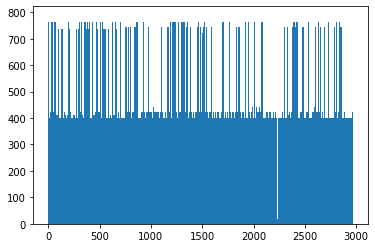

In [20]:
unique, counts = np.unique(y, return_counts=True)
balance = dict(zip(unique, counts))

plt.bar(range(0, len(counts)), counts, width=1.0)
plt.show()